### 🧩 Needed Imports


In [1]:
import random
import math
from typing import List
from typing import Dict
from typing import Tuple
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

### 🧩 Utility Functions for Taskset Generation

---

#### 🔧 `generate_semi_harmonic_periods(n, Tmin, Tmax, factor=2, nonharmonic_prob=0.1)`

**Purpose**:
Generates a list of `n` task periods, where most are *harmonic* (multiples of a base value), but some are intentionally *non-harmonic* to reflect real-world variability.

**How It Works**:
- First, builds a list of harmonic periods by starting at `Tmin` and multiplying by `factor` until `Tmax` is reached.
- Then, it samples `n` periods:
  - With probability `1 - nonharmonic_prob` (default 90%), it picks a harmonic period from the list.
  - With probability `nonharmonic_prob` (default 10%), it picks a non-harmonic random integer not in the base list.

**Parameters**:
- `n` *(int)*: Number of periods to generate.
- `Tmin` *(int)*: Minimum base period.
- `Tmax` *(int)*: Maximum period value.
- `factor` *(int)*: Harmonic multiplier between base periods (default = 2).
- `nonharmonic_prob` *(float)*: Chance of picking a non-harmonic period (default = 0.1).

**Returns**:
- A list of `n` integers representing the task periods.

---

#### 🔧 `uunifast(n, U_total)`

**Purpose**:
Implements the UUniFast algorithm to generate `n` task utilizations that add up exactly to a specified total utilization (`U_total`).

**How It Works**:
- Starts with a total utilization budget.
- Randomly partitions this budget among `n` tasks using a formula that ensures:
  - All utilizations are positive.
  - The total sum is exactly `U_total`.

**Parameters**:
- `n` *(int)*: Number of tasks (utilization values).
- `U_total` *(float)*: Total utilization to distribute across tasks.

**Returns**:
- A list of `n` floating-point values where the sum is exactly `U_total`.

**Why It’s Used**:
- This is a standard and accepted method in real-time systems research for generating fair, realistic task utilizations when simulating tasksets.

---


In [2]:
def generate_semi_harmonic_periods(
        n: int,
        Tmin: int,
        Tmax: int,
        factor: int = 2,
        nonharmonic_prob: float = 0.1
) -> List[int]:
    """Generate semi-harmonic periods with occasional non-harmonic picks."""
    base = []
    p = Tmin
    while p <= Tmax:
        base.append(p)
        p *= factor
    periods = []
    for _ in range(n):
        if random.random() < nonharmonic_prob:
            ph = random.randint(Tmin, Tmax)
            while ph in base:
                ph = random.randint(Tmin, Tmax)
            periods.append(ph)
        else:
            periods.append(random.choice(base))
    return periods


def uunifast(n: int, U_total: float) -> List[float]:
    """UUniFast algorithm to split total utilization into n parts."""
    utilizations = []
    sum_u = U_total
    for i in range(1, n):
        next_u = sum_u * (random.random() ** (1 / (n - i)))
        utilizations.append(sum_u - next_u)
        sum_u = next_u
    utilizations.append(sum_u)
    return utilizations

### ⚙️ Function: `perform_rta_analysis`

**Purpose**:
Performs **fixed-priority Response Time Analysis (RTA)** under **Deadline Monotonic (DM)** scheduling for a single taskset. It calculates the worst-case response time (`R_true`) for each task and determines whether the task — and the entire taskset — is schedulable.

This function assumes that each task already includes deterministic metadata like `task_id`, `taskset_id`, `hp_util`, and `inv_T` (assigned during taskset generation).

---

**How It Works**:

1. **Iterate Over Tasks in DM Order**
   - Assumes tasks are already sorted by deadline.
   - For each task, it calculates interference from all **higher-priority tasks**.

2. **Perform Fixed-Point Iteration**
   - Starts with `R = C`, and iteratively computes:
     - `R_next = C + Σ ceil(R / Tⱼ) × Cⱼ` for all j < i
   - Iteration stops if:
     - `R_next == R` (converged),
     - `R_next > D` (unschedulable),
     - or `max_iter` is reached.

3. **Tag Task as Schedulable or Not**
   - A task is **schedulable** if `R ≤ D` and convergence occurred within iteration bounds.
   - `R_true` is assigned the final converged value (or `None` if unschedulable).

4. **Determine Set-Level Schedulability**
   - Adds `"set_schedulable"` field to all tasks: 1 if **all** tasks are schedulable, otherwise 0.

---

**Parameters**:
- `tasks` *(List[Dict])*: List of task dictionaries, each with precomputed metadata.
- `max_iter` *(int)*: Maximum number of iterations for RTA convergence (default = 1000).

---

**Returns**:
- A list of task dictionaries with **three additional fields**:
  - `"R_true"`: Worst-case response time (or `None` if unschedulable)
  - `"schedulable"`: 1 if `R_true ≤ D`, else 0
  - `"set_schedulable"`: 1 if all tasks in the taskset are schedulable, else 0

---

**Why It Matters**:
This function provides **ground truth labels** for ML models using classical RTA. It is critical for:
- Binary classification (schedulable vs. not)
- Regression targets (`R_true`)
- Validating and comparing ML estimations against analytical methods

It enforces real-time correctness by respecting fixed-priority scheduling semantics and upper-bound constraints.


In [3]:
def perform_rta_analysis(tasks: List[Dict], max_iter: int = 1000) -> List[Dict]:
    results = []

    for idx, task in enumerate(tasks):
        T, C, D = task["T"], task["C"], task["D"]

        # quick infeasibility check
        if D > T or C > D:
            results.append({**task, "R_true": None, "schedulable": 0})
            continue

        # fixed-point iteration
        R = C
        iters = 0
        while True:
            interference = sum(
                math.ceil(R / hp["T"]) * hp["C"]
                for hp in tasks[:idx]  # higher-priority tasks only
            )
            R_next = C + interference
            if R_next == R or R_next > D or iters >= max_iter:
                R = R_next
                break
            R = R_next
            iters += 1

        sched = int(R <= D and iters < max_iter)
        R_out = R if sched else None

        results.append({**task, "R_true": R_out, "schedulable": sched})

    # Set-level schedulability flag
    set_schedulable_flag = int(all(task["schedulable"] == 1 for task in results))
    for task in results:
        task["set_schedulable"] = set_schedulable_flag

    return results

### ⚙️ Function: `generate_task_list`

**Purpose**:
Generates a **synthetic fixed-priority real-time taskset** with `n` tasks and a target total utilization `U_total`. Each task is assigned realistic timing parameters (T, C, D, U), and annotated with metadata fields (`task_id`, `taskset_id`, `hp_util`, `inv_T`) needed for schedulability analysis or ML model training.

---

**How It Works**:

1. **Generate Semi-Harmonic Periods**
   - Calls `generate_semi_harmonic_periods()` to create task periods (`T`), which are mostly harmonic but may include some non-harmonic values based on `nonharmonic_prob`.

2. **Distribute Utilization Using UUniFast**
   - Splits `U_total` across `n` tasks using the `uunifast()` algorithm, ensuring that ∑Uᵢ = U_total.

3. **Compute Execution Times and Deadlines**
   - For each task:
     - Execution time: `C = U × T`
     - Deadline `D` is assigned:
       - With probability `tight_deadline_prob`, it's tight (just above `C`)
       - Otherwise, `D` is looser, randomly between `C` and `T`
     - The number of tasks (`"n_tasks"`) is stored as metadata.

4. **Optional Overload Injection**
   - With probability `overload_prob`, one task is randomly selected and made **unschedulable** by inflating its `C` by 1.5×. Its `D` and `U` are adjusted accordingly.
   - If `U_total ≥ 0.8`, the overload chance increases to 0.2.

5. **Sort Tasks by Deadline (DM Scheduling)**
   - Tasks are sorted in ascending order of deadlines to reflect **Deadline Monotonic (DM)** priority assignment.

6. **Attach Metadata Fields**
   For each task in sorted order, the following fields are computed:
   - `"task_id"`: Index of the task (based on DM order)
   - `"taskset_id"`: External ID to group tasks from the same set
   - `"hp_util"`: Sum of utilizations of all higher-priority tasks
   - `"inv_T"`: Inverse of the period (1 / T)
   - `"U_total"`: Total Utilization

---

**Parameters**:
- `n` *(int)*: Number of tasks to generate.
- `U_total` *(float)*: Total utilization for the taskset.
- `taskset_id` *(int)*: Unique ID for the taskset (default = 0).
- `Tmin` / `Tmax` *(int)*: Range of task periods.
- `tight_deadline_prob` *(float)*: Probability of assigning a tight deadline (default = 0.5).
- `nonharmonic_prob` *(float)*: Chance of assigning non-harmonic period (default = 0.1).
- `overload_prob` *(float)*: Chance of inflating a task’s execution time to cause overload (default = 0.05).

---

**Returns**:
A tuple `(task_list, U_total)` where:
- `task_list` is a list of `n` dictionaries. Each dictionary contains:
  - `"T"`: Period
  - `"C"`: Execution time
  - `"D"`: Deadline
  - `"U"`: Utilization
  - `"n_tasks"`: Total number of tasks in the set
  - `"task_id"`: Index in sorted DM order
  - `"taskset_id"`: Unique taskset ID
  - `"hp_util"`: Higher-priority utilization sum
  - `"inv_T"`: Inverse of the period (1 / T)
  - `"U_total"`: Total Utilization

---

**Why It Matters**:
This function forms the core of dataset generation for real-time systems research. It systematically produces diverse and realistic tasksets that enable:
- Controlled testing of RTA and ML models
- Labeling for **schedulability classification**
- Feature extraction for **WCRT regression**
- Simulation of corner cases (tight deadlines, non-harmonic timing, overloads)

It ensures data quality and traceability by embedding all relevant features and identifiers into each task entry.


In [4]:
def generate_task_list(
        n: int,
        U_total: float,
        taskset_id: int = 0,
        Tmin: int = 10,
        Tmax: int = 1000,
        tight_deadline_prob: float = 0.5,
        nonharmonic_prob: float = 0.1,
        overload_prob: float = 0.05,
) -> Tuple[List[Dict], float]:

    # 1) Periods (semi-harmonic)
    periods = generate_semi_harmonic_periods(n, Tmin, Tmax, nonharmonic_prob=nonharmonic_prob)

    # 2) Utilization split
    utilizations = uunifast(n, U_total)

    tasks = []
    for i in range(n):
        T = periods[i]
        U = utilizations[i]
        C = U * T
        # Deadline assignment
        if random.random() < tight_deadline_prob:
            slack = max(int(0.1 * T), 1)
            D = min(T, math.ceil(C) + random.randint(0, slack))
        else:
            D = random.randint(math.ceil(C), T)
        tasks.append({
            "T": T,
            "C": C,
            "D": D,
            "U": U,
            "n_tasks": n  # for later flattening
        })

    # 3) Optional overload injection
    dynamic_overload_prob = 0.2 if U_total >= 0.8 else overload_prob
    if random.random() < dynamic_overload_prob and tasks:
        victim = random.choice(tasks)
        victim["C"] *= 1.5
        victim["U"] = victim["C"] / victim["T"]
        if victim["D"] < math.ceil(victim["C"]):
            victim["D"] = math.ceil(victim["C"])

    # 4) Sort by deadline for correct DM ordering
    tasks.sort(key=lambda x: x["D"])

    # 5) Add metadata fields (task_id, hp_util, etc.)
    for i, task in enumerate(tasks):
        task["task_id"] = i
        task["taskset_id"] = taskset_id
        task["hp_util"] = sum(t["U"] for t in tasks[:i])
        task["inv_T"] = 1.0 / task["T"]
        task["U_total"] = U_total

    return tasks, U_total

### 📦 Function: `generate_dataset_csv`

**Purpose**:
Generate and save a synthetic real-time taskset dataset with exact **RTA labels**.
Each taskset is created using `generate_task_list`, analyzed with `perform_rta_analysis`, and stored in a **flat CSV** (one row per task).
A JSON metadata file is also saved to record all generation parameters for reproducibility.

---

**Parameters**:
- `output_path` *(str)*: Path to save the dataset CSV.
- `n_range` *(list[int], optional)*: Number of tasks per set (default = [5..20]).
- `utilization_bins` *(list[float], optional)*: Target total utilizations (default = [0.2, 0.4, 0.6, 0.8, 1.0]).
- `samples_per_combination` *(int, default=500)*: Tasksets to generate for each (n, U) pair.
- `random_seed` *(int, default=42)*: Random seed for reproducibility.

---

**Returns**:
- `pd.DataFrame`: The generated dataset (also written to CSV).


In [6]:
def generate_dataset_csv(
        output_path: str,
        n_range=None,
        utilization_bins=None,
        samples_per_combination: int = 500,
        random_seed: int = 42
):
    # Check if file already exists
    if os.path.exists(output_path):
        print(f"📁 Dataset already exists at: {output_path}")
        return None

    # Step 1: Set random seed globally
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Step 2: Default params
    if utilization_bins is None:
        utilization_bins = [0.2, 0.4, 0.6, 0.8, 1.0]
    if n_range is None:
        n_range = list(range(5, 21))

    taskset_id = 0
    all_tasks = []

    for n in n_range:
        for U in utilization_bins:
            for _ in range(samples_per_combination):
                task_list, U_total = generate_task_list(n=n, U_total=U, taskset_id=taskset_id)
                labeled_tasks = perform_rta_analysis(task_list)
                all_tasks.extend(labeled_tasks)
                taskset_id += 1

    # Step 3: Save CSV
    df = pd.DataFrame(all_tasks)
    df.to_csv(output_path, index=False)

    # Step 4: Save metadata for reproducibility
    metadata = {
        "random_seed": random_seed,
        "samples_per_combination": samples_per_combination,
        "utilization_bins": utilization_bins,
        "n_range": n_range,
        "Tmin": 10,
        "Tmax": 1000,
        "tight_deadline_prob": 0.5,
        "nonharmonic_prob": 0.1,
        "overload_prob": 0.05
    }

    with open(output_path.replace(".csv", "_metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    return df

In [6]:
generate_dataset_csv("../data/main_dataset.csv", samples_per_combination=10000)


📁 Dataset already exists at: ../data/main_dataset.csv


📊 Dataset Summary
------------------
Total task sets       : 800000
Total tasks           : 10000000
Task count per set    : 5 to 20


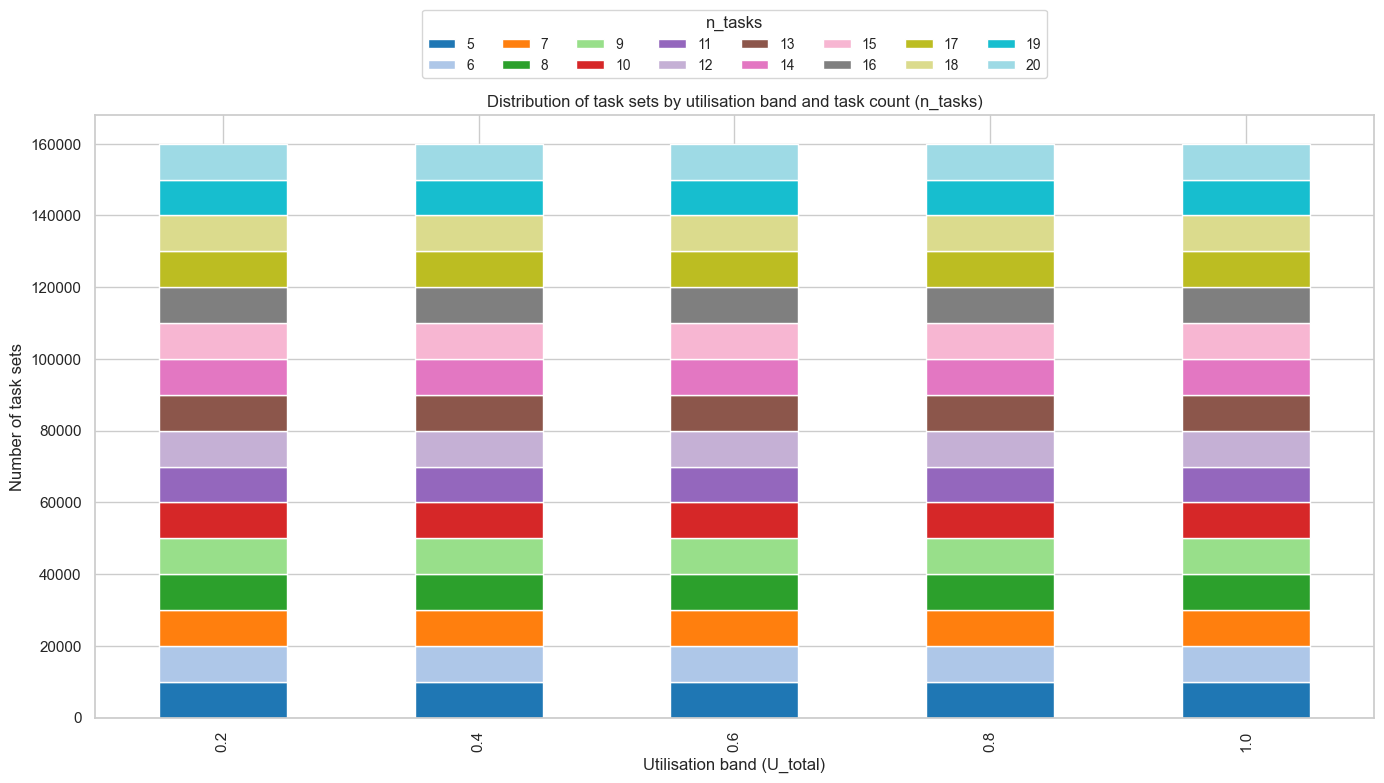


🧮 Set-Level Schedulability:
  0 = Not Schedulable → 634683 sets
  1 = Schedulable     → 165317 sets


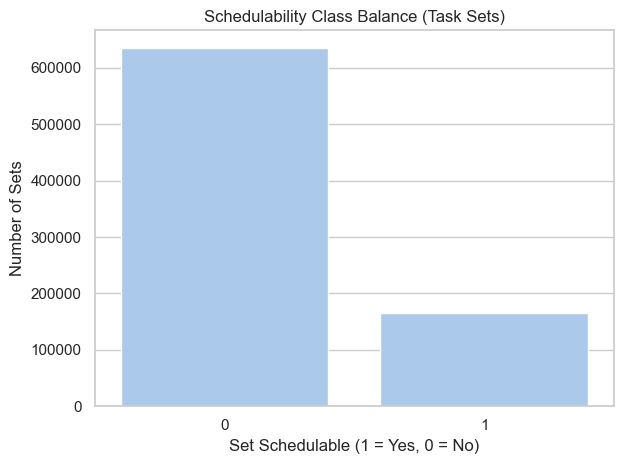


🧮 Task-Level Schedulability:
  0 = Not Schedulable → 3430107 tasks
  1 = Schedulable     → 6569893 tasks


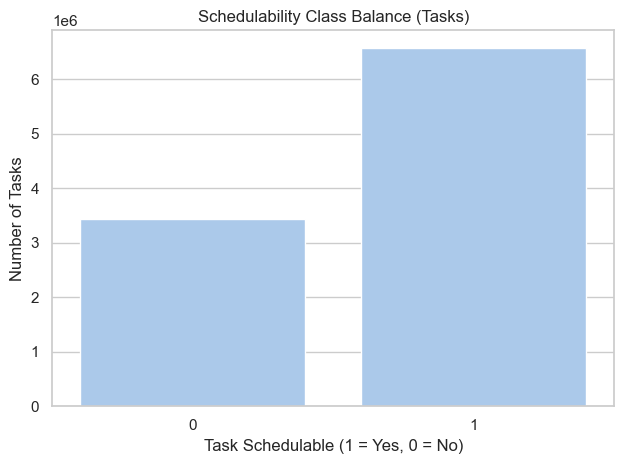

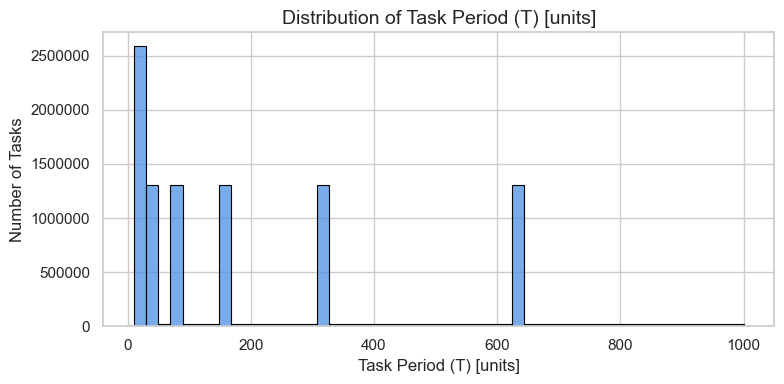

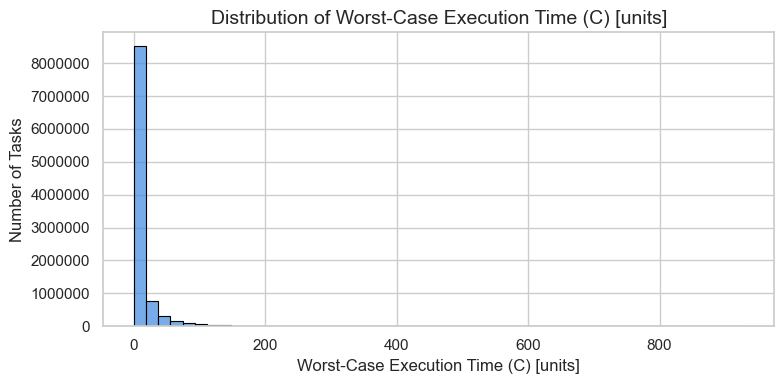

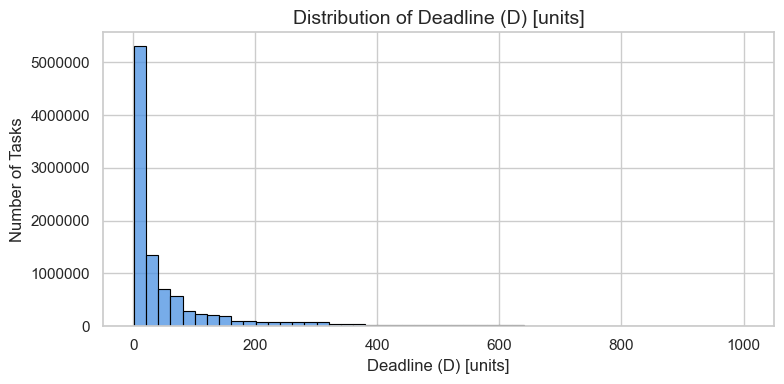

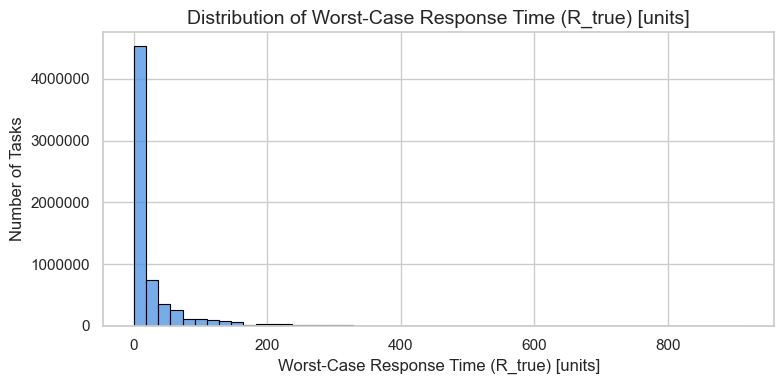

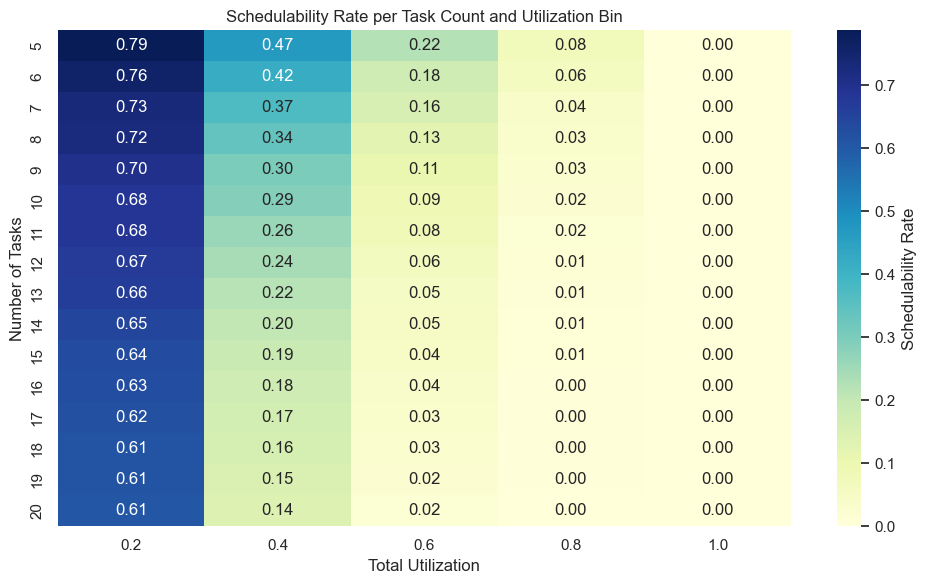

In [14]:
# Load the generated dataset
df = pd.read_csv("../data/main_dataset.csv")

# === Rreadable feature labels ===
feature_labels = {
    "T": "Task Period (T) [units]",
    "C": "Worst-Case Execution Time (C) [units]",
    "D": "Deadline (D) [units]",
    "R_true": "Worst-Case Response Time (R_true) [units]"
}

sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams["axes.formatter.useoffset"] = False

def print_basic_summary(df):
    print("📊 Dataset Summary")
    print("------------------")
    print(f"Total task sets       : {df['taskset_id'].nunique()}")
    print(f"Total tasks           : {len(df)}")
    print(f"Task count per set    : {df['n_tasks'].min()} to {df['n_tasks'].max()}")


def plot_schedulability_distribution(df):
    print("\n🧮 Set-Level Schedulability:")
    set_stats = df.drop_duplicates("taskset_id")[["taskset_id", "set_schedulable"]]
    set_counts = set_stats["set_schedulable"].value_counts().sort_index()
    print(f"  0 = Not Schedulable → {set_counts.get(0, 0)} sets")
    print(f"  1 = Schedulable     → {set_counts.get(1, 0)} sets")

    sns.countplot(x="set_schedulable", data=set_stats)
    plt.title("Schedulability Class Balance (Task Sets)")
    plt.xlabel("Set Schedulable (1 = Yes, 0 = No)")
    plt.ylabel("Number of Sets")
    plt.tight_layout()
    plt.show()

    print("\n🧮 Task-Level Schedulability:")
    task_counts = df["schedulable"].value_counts().sort_index()
    print(f"  0 = Not Schedulable → {task_counts.get(0, 0)} tasks")
    print(f"  1 = Schedulable     → {task_counts.get(1, 0)} tasks")

    sns.countplot(x="schedulable", data=df)
    plt.title("Schedulability Class Balance (Tasks)")
    plt.xlabel("Task Schedulable (1 = Yes, 0 = No)")
    plt.ylabel("Number of Tasks")
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(df, features):
    for f in features:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[f].dropna(), bins=50, color="#4a90e2", edgecolor="black")
        plt.title(f"Distribution of {features[f]}", fontsize=14)
        plt.xlabel(features[f])
        plt.ylabel("Number of Tasks")
        plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
        plt.tight_layout()
        plt.show()

def plot_schedulability_heatmap(df):
    df_grouped = df.groupby(['n_tasks', 'U_total'])['set_schedulable'].mean().reset_index()
    heatmap_data = df_grouped.pivot(index='n_tasks', columns='U_total', values='set_schedulable')

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",
                cbar_kws={'label': 'Schedulability Rate'})
    plt.title("Schedulability Rate per Task Count and Utilization Bin")
    plt.xlabel("Total Utilization")
    plt.ylabel("Number of Tasks")
    plt.tight_layout()
    plt.show()

def plot_taskset_distribution(df: pd.DataFrame) -> None:
    dist = df.groupby(['U_total', 'n_tasks'])['taskset_id'].nunique().unstack(fill_value=0)

    # Plot stacked bar
    dist.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 8),
        colormap="tab20"
    )

    plt.title("Distribution of task sets by utilisation band and task count (n_tasks)")
    plt.xlabel("Utilisation band (U_total)")
    plt.ylabel("Number of task sets")
    plt.legend(title="n_tasks", bbox_to_anchor=(0.5, 1.05), loc='lower center',
               ncol=8, fontsize=10, frameon=True)
    plt.tight_layout()
    plt.show()


# Run All Checks
print_basic_summary(df)
plot_taskset_distribution(df)
plot_schedulability_distribution(df)
plot_feature_distributions(df, feature_labels)
plot_schedulability_heatmap(df)
